In [1]:
#Make sure to address all inter-dependencies and packages installations

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
dfCSI = pd.read_csv("C:/Users/Nicola/Desktop/BRACED Final Evaluation/Monitoring Tools and Data/Processing Data/CSI_reviewed1.csv",encoding='latin-1')
# Dataset Uploaded from Coping Strategy Index dataset 

In [4]:
#What is CSI: Check this online 
#https://www.wfp.org/content/coping-strategies-index-field-methods-manual-2nd-edition)

In [5]:
dfCSI.rename(columns={'CSI score assets':'CSIAssets'},inplace=True)
Base=dfCSI.loc[dfCSI['Study'] == 'Baseline']
Base = Base.apply(pd.to_numeric, errors='coerce')
End=dfCSI.loc[dfCSI['Study'] == 'Endline']
End = End.apply(pd.to_numeric, errors='coerce')
len(Base),len(End)

(550, 746)

In [6]:
1-(Base.CSI_food.mean()/End.CSI_food.mean())

0.6947973161402035

In [7]:
CSIAssets=dfCSI.CSIAssets.apply(pd.to_numeric, errors='coerce')
CSIfood=dfCSI.CSI_food.apply(pd.to_numeric, errors='coerce')

In [8]:
1-(Base.CSIAssets.mean()/End.CSIAssets.mean())

0.2969372693726937

In [9]:
# Defining new variables
Year=dfCSI.Year.apply(pd.to_numeric, errors='coerce')
Commune=dfCSI.commune

In [10]:
# Define font specifics for graphical visualisation
import matplotlib.font_manager as font_manager
title_font = {'fontname':'Futura', 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Futura', 'size':'15'}
# Set the font properties
font_path = 'C:\Windows\Fonts\Futura.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=14)

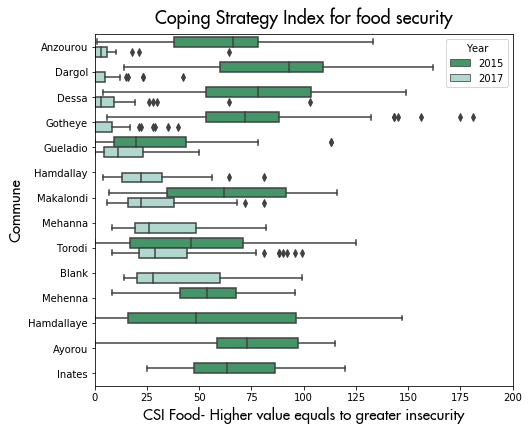

In [11]:
#Boxplot seaborn library parameters
DsgImpF=sns.boxplot(CSIfood,Commune, Year, palette="BuGn_r")
#Disaggregated CSI value for Food per Commune
plt.xlim([0,200])
plt.title('Coping Strategy Index for food security',**title_font)
plt.ylabel('Commune',**axis_font)
plt.xlabel('CSI Food- Higher value equals to greater insecurity',**axis_font)
plt.tight_layout()
#Graph Into Figure
figure = DsgImpF.get_figure()
figure.set_size_inches(8, 7)
# Save in png format and adjust resolution
#figure.savefig('CSIFood.png', dpi=1000)

#Interpretation- Significant drop in CSI for food, less food insecurity 

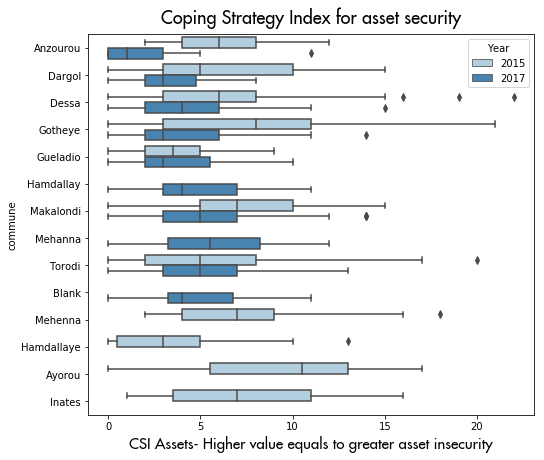

In [12]:
Assets=sns.boxplot(CSIAssets,Commune, Year, palette="Blues")
plt.title('Coping Strategy Index for asset security',**title_font)
plt.xlabel('CSI Assets- Higher value equals to greater asset insecurity',**axis_font)
figure = Assets.get_figure()
figure.set_size_inches(8, 7)
#Drop in CSI for asset as well, less asset insecurity 

In [13]:
#import packages to visualise words processing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models
import gensim

C:\Users\Nicola\Anaconda3\envs\r\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
dfCSIQual = pd.read_csv("C:/Users/Nicola/Desktop/BRACED Final Evaluation/Final Evaluation Process and CSI/CSI Evaluation_2018.csv",encoding='latin-1')

In [15]:
# one-review-per-line of the new file with all qualitative evidence
def parse(dfCSIQual):
    g = gzip.open(dfCSI, 'rb')
    for l in g:
        yield eval(l)
def getDF(dfCSIQual):
    i = 0
    df = {}
    for d in parse(dfCSIQual):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [16]:
#Select and shape columns with text to be processed
analysis=dfCSIQual[['Q_3','Q_5','Q_7','Q_9','Q_11','Q_13','Q_15','Q_17','Q_19','Q_21','Q_23','Q_25','Q_27','Q_29']].dropna()
', '.join(analysis)
analysis.shape
analysis=pd.melt(analysis)
print(analysis.head(2))

  variable                                              value
0      Q_3     2 membres comité et 12bénéficiaires warrantage
1      Q_3  Warrantage, BC, jardins maraîchers et PFLN, VS...


In [17]:
print(analysis.ndim)
print(analysis.size)

2
588


In [18]:
#remove punctuation from melted text
import string
exclude = set(string.punctuation)
def remove_punctuation(x):
    try:
        x = ''.join(ch for ch in x if ch not in exclude)
    except:
        pass
    return x
analysis1 = analysis.apply(remove_punctuation)

In [19]:
# Define the clean list as set of word to be tokenized
words=pd.DataFrame(analysis1)
raw=words.as_matrix().flatten()

In [20]:
#tokenize words
import nltk
def tokenize(word):
    return word
tokenized = [tokenize(word) for sentence in raw for word in sentence.split()]

In [21]:
# clean the bag of words form stop words, set the language in French for this dataset
from stop_words import get_stop_words
fr_stop = get_stop_words('fr')
stopped_tokens = [i for i in tokenized if not i in fr_stop]
nltk_stpwd = stopwords.words('french')
stop_words_stpwd = get_stop_words('fr')
merged_stopwords = list(set(nltk_stpwd + fr_stop))
sb_stemmer = SnowballStemmer('french')

In [22]:
#Shape the text in a way to create a cleaner dictionary
num_reviews = analysis.shape[0]
doc_set = [analysis1.value for i in range(num_reviews)]
texts = []
for doc in doc_set:
    stopped_tokens = [token for token in tokenized if not token in merged_stopwords]
    stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
    # add tokens to list
    texts.append(stopped_tokens)
print (texts[1:1])

[]


In [23]:
#Creat dictionary
texts_dict = corpora.Dictionary(texts)
texts_dict.save('auto_review.dict') # lets save to disk for later use
# Examine each token’s unique id
print(texts_dict)

Dictionary(1011 unique tokens: ['(', '(15000fcfa),', '(CFW)Cash', '(CFW)agriculteurs', '(CFW,']...)


In [24]:
id2word = gensim.corpora.Dictionary()
corpus = [texts_dict.doc2bow(text) for text in texts]
len(corpus)
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim

In [25]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=texts_dict)

In [26]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=texts_dict)

In [27]:
lsimodel.show_topics(num_topics=5)
lsitopics = lsimodel.show_topics(formatted=True)

In [28]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=texts_dict)

In [29]:
import pyLDAvis.gensim

In [30]:
pyLDAvis.enable_notebook()

In [31]:
pyLDAvis.gensim.prepare(ldamodel, corpus, texts_dict)

C:\Users\Nicola\Anaconda3\envs\r\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      24.755216        1       1  0.002666  0.002097
1      20.458610        1       2  0.002908 -0.001496
2      19.451141        1       3 -0.000678 -0.000701
0      18.306243        1       4 -0.002187 -0.002771
3      17.028790        1       5 -0.002709  0.002871, topic_info=     Category          Freq             Term         Total  loglift  logprob
term                                                                        
836   Default  22197.000000         semences  22197.000000  30.0000  30.0000
702   Default  10722.000000         pratique  10722.000000  29.0000  29.0000
574   Default   5425.000000      maraîchage,   5425.000000  28.0000  28.0000
32    Default   7189.000000              AGR   7189.000000  27.0000  27.0000
625   Default   4251.000000          ménages   4251.000000  26.0000  26.0000
164   Default  13559.000000       améliorées  13559.000000  25.0000  25.0000
970   Default   6823.000000      warrantage,   6823.000000  24.0000  24.0000
687   Default  10883.000000           permis  10883.000000  23.0000  23.0000
911   Default   4535.000000   transformation   4535.000000  22.0000  22.0000
324   Default   7705.000000          crédits   7705.000000  21.0000  21.0000
496   Default   4747.000000         initiées   4747.000000  20.0000  20.0000
507   Default   3927.000000           issues   3927.000000  19.0000  19.0000
966   Default  11500.000000       warrantage  11500.000000  18.0000  18.0000
355   Default   3292.000000         d'éviter   3292.000000  17.0000  17.0000
479   Default   2731.000000      groupements   2731.000000  16.0000  16.0000
116   Default   4184.000000          acheter   4184.000000  15.0000  15.0000
42    Default   4779.000000               BC   4779.000000  14.0000  14.0000
315   Default   3584.000000        contribué   3584.000000  13.0000  13.0000
320   Default   5302.000000           crédit   5302.000000  12.0000  12.0000
684   Default   3577.000000           permet   3577.000000  11.0000  11.0000
799   Default   9356.000000          revenus   9356.000000  10.0000  10.0000
121   Default  14878.000000        activités  14878.000000   9.0000   9.0000
835   Default   1789.000000          semence   1789.000000   8.0000   8.0000
688   Default   4673.000000            petit   4673.000000   7.0000   7.0000
0     Default   3571.000000                (   3571.000000   6.0000   6.0000
401   Default   3976.000000  diversification   3976.000000   5.0000   5.0000
481   Default  12415.000000            grâce  12415.000000   4.0000   4.0000
765   Default   3800.000000          période   3800.000000   3.0000   3.0000
346   Default   2993.000000         d'autres   2993.000000   2.0000   2.0000
559   Default   2055.000000           manger   2055.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
200    Topic5    487.445248            assez   2365.307495   0.1908  -5.5832
191    Topic5    191.441540           appuyé    883.341145   0.2411  -6.5178
393    Topic5    854.309583    disponibilité   4412.652716   0.1283  -5.0220
320    Topic5   1010.041602           crédit   5302.668745   0.1120  -4.8546
970    Topic5   1274.957051      warrantage,   6823.331613   0.0928  -4.6217
116    Topic5    810.026283          acheter   4184.078977   0.1283  -5.0753
687    Topic5   1935.398092           permis  10883.301447   0.0433  -4.2043
983    Topic5    366.777933              y'a   1787.746904   0.1863  -5.8676
121    Topic5   2568.630327        activités  14878.348038   0.0137  -3.9212
851    Topic5    823.974122        situation   4394.502254   0.0963  -5.0582
355    Topic5    621.899578         d'éviter   3292.436111   0.1037  -5.3396
732    Topic5    357.293130      productions   1771.922179   0.1690  -5.8938
725    Topic5   1316.630480       production   7734.765900  -0.0004  -4.5895
507    Topic5    723.923790          